### **Proyecto #1 Inteligencia de Negocios: Analítica de Textos**

Autores:
*   Martin Santiago Galvan Castro
*   Ernesto Carlos Perez Covo
*   Juan Sebastian Nuñez Cortes


### **0. Instalacion e imports de librerias**

In [217]:
import sys
# Version 3.8 de Python requerida

#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install contexto
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install openpyxl
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install langdetect

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from contexto.limpieza import limpieza_texto, lista_stopwords, remover_stopwords
from contexto.stemming import Stemmer, stem_texto
from contexto.vectorizacion import VectorizadorFrecuencias

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from langdetect import detect

### **1. Exploracion de datos**

In [219]:
df = pd.read_excel('cat_6716.xlsx')

In [220]:
# Contar valores nulos
df.isnull().sum()

Textos_espanol    0
sdg               0
dtype: int64

In [221]:
# Contar duplicados
df.duplicated().sum()

0

In [222]:
# Detectar si hay otros idiomas ademas de español.
df['lang'] = df['Textos_espanol'].apply(lambda x: detect(x))
df['lang'].value_counts()

lang
es    2996
en       4
Name: count, dtype: int64

In [223]:
# Imprimir los textos que no son español
for i in range(len(df)):
    if df['lang'][i] != 'es':
       print(i, df['Textos_espanol'][i])

403 Subvenciones al agua: Impact of higher irrigation rates on Central Valley Project farmers. United States General Accounting Office, GAO/RCED-94-8, Washington, D.C., 92 páginas. Oficina de Reclamación: Información sobre la asignación y reembolso de los costes de construcción de proyectos hidráulicos. United States General Accounting Office, GAO/RCED-96-109, Washington, D.C., 80 páginas.
1317 Project Finance NewsWire, Discussion with four project finance bankers, moderated by Rohit Chadhry, Chadboume & Parke, pp. Investment Monitor 2Q 2010, vol. Policy instrument design to reduce financing costs in renewable energy technology projects, ECOFYS, Utrecht. Reestructuración de una red verde: Legal challenges to accommodate new renewable energy infrastructure. Environmental Law, 39, 977-1014. 
1553 Innovación en tecnología energética: Aprender de los éxitos y fracasos históricos. New York: Cambridge University Press. Transformation Patterns of the Worldwide Energy Systemâ€"Scenarios for th

In [224]:
# Hay unicamente una frase en ingles, las otras tienen porciones tanto en español como en ingles. No se elimina ninguna debio a que, al probarlo, se redujo la precision del modelo.
# df = df[df['lang'] == 'es']
# df['lang'].value_counts()

In [225]:
df['Conteo'] = [len(x) for x in df['Textos_espanol']]
df['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in df['Textos_espanol']]
df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['Textos_espanol']]
df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['Textos_espanol']]

In [226]:
# Se genero un reporte con ydata_profiling. Se guardo este reporte bajo el nombre report.html
# profile = ProfileReport(df)
# profile.to_file("report.html")

<Axes: xlabel='Conteo', ylabel='Count'>

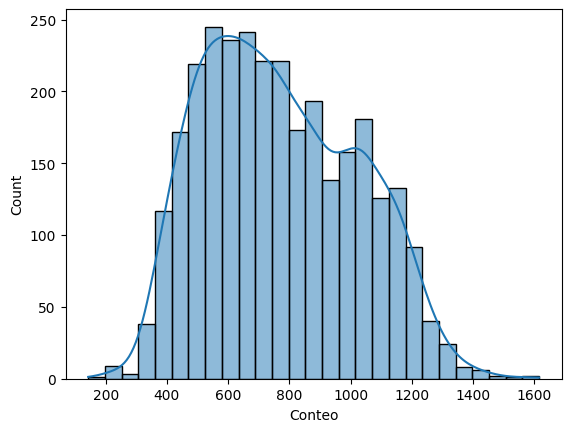

In [227]:
sns.histplot(data=df, x='Conteo', kde=True)

<Axes: xlabel='Min', ylabel='Count'>

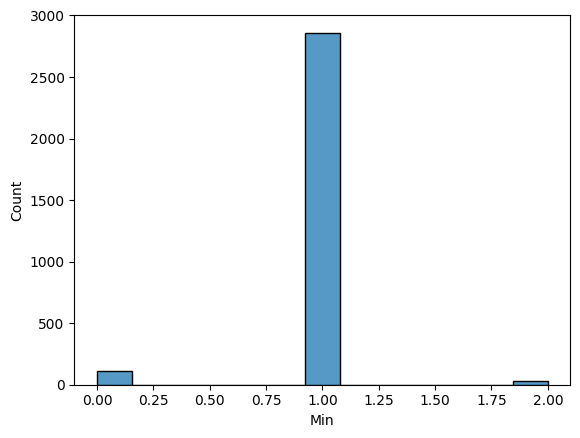

In [228]:
sns.histplot(data=df, x='Min')

<Axes: xlabel='Max'>

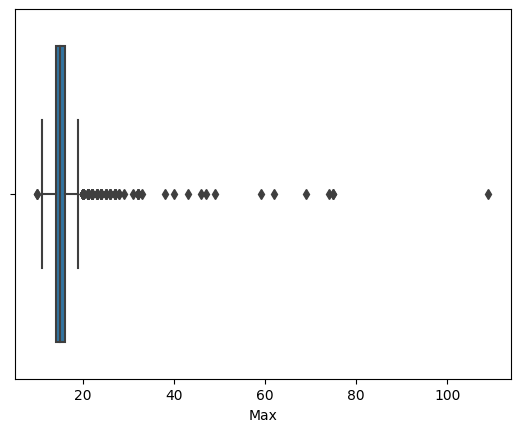

In [229]:
sns.boxplot(x=df['Max'])

In [230]:
df['Moda'].value_counts()

Moda
de               2563
la                240
y                  48
en                 36
el                 29
los                16
las                10
del                 8
que                 7
para                6
a                   5
se                  4
agua                3
más                 2
internacional       2
derecho             2
por                 2
the                 2
energía             1
Capítulo            1
social              1
La                  1
and                 1
o                   1
Directiva           1
to                  1
un                  1
sobre               1
lago                1
institucional       1
costo               1
río                 1
historia            1
Name: count, dtype: int64

In [231]:
df.head()

,Textos_espanol,sdg,lang,Conteo,Moda,Max,Min
0,"Es importante destacar que, en un año de sequí...",6,es,621,de,16,1
1,Hay una gran cantidad de literatura sobre Aust...,6,es,881,de,15,1
2,"Los procesos de descentralización, emprendidos...",6,es,579,la,18,1
3,Esto puede tener consecuencias sustanciales pa...,6,es,706,de,14,1
4,La función de beneficio también incorpora pará...,6,es,673,de,12,1


### **2. Separacion de datos**

In [232]:
X, Y = df['Textos_espanol'], df['sdg']
Y = Y.astype(int)
Y.head()

0    6
1    6
2    6
3    6
4    6
Name: sdg, dtype: int32

In [233]:
X.head()

0    Es importante destacar que, en un año de sequí...
1    Hay una gran cantidad de literatura sobre Aust...
2    Los procesos de descentralización, emprendidos...
3    Esto puede tener consecuencias sustanciales pa...
4    La función de beneficio también incorpora pará...
Name: Textos_espanol, dtype: object

In [234]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [235]:
X_train.head()

2370    Lograr el respeto de los derechos humanos por ...
1774    Diseño de proyectos sostenibles de electrifica...
731     En las partes españolas de las cuencas del Due...
271     Garantizar que los arreglos de gobernanza ayud...
1077    Además, a nivel de plantas y unidades, no hay ...
Name: Textos_espanol, dtype: object

### **3. Modelo #1: Naive Bayes**

Para el pipeline, se realiza la limpieza, normalización (stemmming), vectorización y clasificación de los datos.

In [236]:
"""
Limpieza de datos. La funcion limpieza_texto hace lo siguiente:
    - Pasar todo el texto a minúsculas
    - Quitar signos de puntuación
    - Quitar números (configurable): True
    - Quitar acentos (configurable). True

Luego, se remueven las stopwords del texto. Para esto, se utiliza la función remover_stopwords.
"""

class TextTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.stopwords = lista_stopwords()
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.preprocess_text(x))
        return X
    
    def preprocess_text(self, texto):
        texto = limpieza_texto(texto=texto, quitar_numeros=True, quitar_acentos=True)
        texto = remover_stopwords(texto, self.stopwords)
        return texto

In [237]:
"""
Normalización de datos. Se utiliza la función stem_texto para realizar el stemming de los textos.
El Stemmer se inicializa antes con el objetivo de que no se cree uno nuevo por cada texto.
"""
class NormalizeTokens(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.stemmer = Stemmer(lenguaje='español')
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.normalize_text(x))
        return X
    
    def normalize_text(self, texto):
        texto = stem_texto(texto=texto, stemmer=self.stemmer)
        return texto

In [238]:
"""
Vectorización de datos. Se utiliza la clase VectorizadorFrecuencias para realizar la vectorización de los textos.
Se crea un vectorizador antes con el objetivo de que no se cree uno nuevo por cada texto.
"""

class VectorizeTokens(BaseEstimator, TransformerMixin):

    def __init__(self, tipo_vec='bow'):
        self.tipo_vec = tipo_vec

    def fit(self, X, y=None):
        # Construcción del vectorizador usando X_train. Se hacer una lista, 
        # donde cada elemento es un string de la posicion Textos_espanol
        textos = [x for x in X]
        self.v_bow = VectorizadorFrecuencias(tipo=self.tipo_vec)
        self.v_bow.ajustar(textos)
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.vectorize_text(x))
        X = X.values.tolist()
        return X
    
    def vectorize_text(self, texto):
        texto = self.v_bow.vectorizar(textos=texto, disperso=False)
        # Se convierte a array para que sea compatible con el resto de los pasos
        # v_bow.inversa(X_vector[0]). Retorna las palabras que corresponden a cada posición del vector
        texto = texto.ravel()
        return texto

In [239]:
# Entrenamiento y construcción del modelo. Se utiliza como clasificador un Complement Naive Bayes.
pipelineCNB = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", ComplementNB())
    ]
)   
pipelineCNB.fit(X_train, Y_train)

Pipeline(steps=[('text_transformer', TextTransformer()),
                ('normalize_tokens', NormalizeTokens()),
                ('vectorize_tokens', VectorizeTokens()),
                ('classifier', ComplementNB())])

In [240]:
# Evaluación del modelo con los datos de prueba.
y_pred = pipelineCNB.predict(X_test)

In [241]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 10
Porcentaje de acierto:  98.33333333333333


In [242]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           6       1.00      0.97      0.98       237
           7       0.98      0.99      0.99       187
          16       0.97      0.99      0.98       176

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



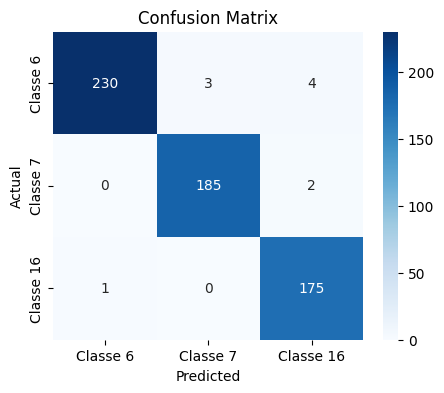

In [243]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)

# Etiquetas de las clases
class_labels = ['Classe 6', 'Classe 7', 'Classe 16']

# Heatmap de la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **4. Modelo #2: SGD**

In [244]:
"""
Entrenamiento y construcción del modelo. 
SGDC Classifier, cuando tiene el parametro de hinge, implementa SVM lineal. Se implementa de esta manera para no tener que lidear con el kernel,
y los resultados que da son suficientemenet satisfactorios.
"""

pipelineSDG = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", SGDClassifier(loss='hinge', penalty='l2',
                    alpha=1e-3, max_iter=5, tol=None)) 
    ]
) 

In [245]:
parameters = {
    'vectorize_tokens__tipo_vec': ('bow', 'tfidf'),
    'classifier__alpha': (1e-2,1e-3),
    'classifier__penalty': ('l2','l1')
}

In [246]:
gs_pipelineSDG = GridSearchCV(pipelineSDG, parameters, cv=5, n_jobs=-1)

In [247]:
gs_pipelineSDG.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('text_transformer', TextTransformer()),
                                       ('normalize_tokens', NormalizeTokens()),
                                       ('vectorize_tokens', VectorizeTokens()),
                                       ('classifier',
                                        SGDClassifier(alpha=0.001, max_iter=5,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': (0.01, 0.001),
                         'classifier__penalty': ('l2', 'l1'),
                         'vectorize_tokens__tipo_vec': ('bow', 'tfidf')})

In [248]:
gs_pipelineSDG.best_params_

{'classifier__alpha': 0.001,
 'classifier__penalty': 'l2',
 'vectorize_tokens__tipo_vec': 'tfidf'}

In [249]:
best_pipelineSDG = gs_pipelineSDG.best_estimator_

In [250]:
# Evaluación del modelo con los datos de prueba.
y_pred = best_pipelineSDG.predict(X_test)

In [251]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 10
Porcentaje de acierto:  98.33333333333333


In [252]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           6       0.97      0.99      0.98       237
           7       0.99      0.97      0.98       187
          16       0.99      0.99      0.99       176

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



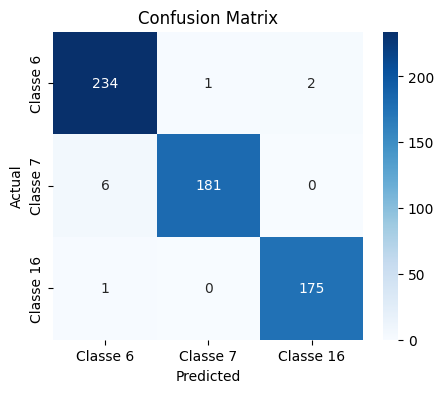

In [253]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)

# Etiquetas de las clases
class_labels = ['Classe 6', 'Classe 7', 'Classe 16']

# Heatmap de la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **5. Modelo #3: Random Forest**

In [254]:
rfc = RandomForestClassifier(random_state=0, bootstrap=False, max_depth=100, n_estimators=184, min_samples_leaf=1, min_samples_split=5, criterion='gini')

pipelineRFC = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", rfc) 
    ]
)

In [255]:
pipelineRFC.fit(X_train, Y_train)

Pipeline(steps=[('text_transformer', TextTransformer()),
                ('normalize_tokens', NormalizeTokens()),
                ('vectorize_tokens', VectorizeTokens()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=100,
                                        min_samples_split=5, n_estimators=184,
                                        random_state=0))])

In [256]:
# Evaluación del modelo con los datos de prueba.
y_pred = pipelineRFC.predict(X_test)

In [257]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 11
Porcentaje de acierto:  98.16666666666667


In [258]:
# Mostrar reporte de clasificación
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           6       0.99      0.96      0.98       237
           7       0.97      0.99      0.98       187
          16       0.98      0.99      0.99       176

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



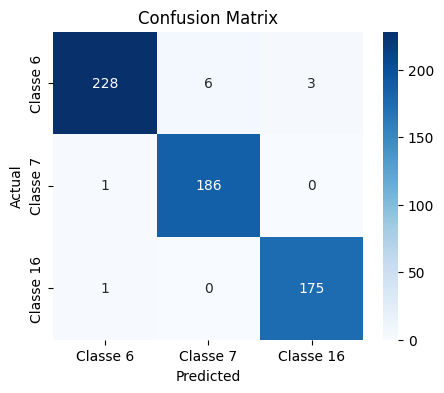

In [259]:
# Matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)

# Etiquetas de las clases
class_labels = ['Classe 6', 'Classe 7', 'Classe 16']

# Heatmap de la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **6. Etiquetado de datos con el mejor modelo**

Para etiquetar los datos, se utiliza el mejor modelo, que en este caso es el de Naive Bayes. A pesar de que en algunos casos el modelo de SGD tiene un mejor accuracy, este no es consistente, ya que de vez en cuando se obtienen 11 de 600 resultados incorrectos y en otros casos 9 de 600. Por lo tanto, se decide utilizar el modelo de Naive Bayes, el cual tiene un porcentaje de acierto de 98.33% en la clasificación de los datos.

In [260]:
df_sin_etiquetas = pd.read_excel('SinEtiquetatest_cat_6716.xlsx')

In [261]:
# Se cuenta con 980 registros y 2 columnas
df_sin_etiquetas.shape

(980, 2)

In [262]:
df_sin_etiquetas.head()

,Textos_espanol,sdg
0,1. 1. Introducción: Las Estructuras del Derech...,NaN
1,Las aguas subterráneas se han debatido en el c...,NaN
2,La presente contribución evalúa la jurispruden...,NaN
3,"Sin embargo, este crédito fiscal expira en 201...",NaN
4,"Este estudio explora las actitudes, comportami...",NaN


In [263]:
datos_etiquetados = pipelineCNB.predict(df_sin_etiquetas['Textos_espanol'])

In [264]:
datos_etiquetados.shape

(980,)

In [265]:
datos_etiquetados[:5]

array([16,  6, 16,  7, 16])

In [266]:
# Agregar las etiquetas al dataframe
df_sin_etiquetas['sdg'] = datos_etiquetados

In [267]:
df_sin_etiquetas.head()

,Textos_espanol,sdg
0,1. 1. Introducción: Las Estructuras del Derech...,16
1,Las aguas subterráneas se han debatido en el c...,6
2,La presente contribución evalúa la jurispruden...,16
3,"Sin embargo, este crédito fiscal expira en 201...",7
4,"Este estudio explora las actitudes, comportami...",16


In [268]:
df_sin_etiquetas.to_csv('EtiquetadosTest_cat_6716.csv', index=False)